In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [3]:
DATA_IN_PATH = 'data-in/'
DATA_OUT_PATH = 'data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIG = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
NALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

print(MAX_LEN)

8


In [7]:
kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_size' : 128,
        'num_filters' : 100,
        'dropout_rate' : 0.5,
        'hidden_dimension' : 250, #히든레이어 노드 수
        'output_dimension' : 1}

In [14]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        #임베딩_특정 저차원으로 옮겨주는 것
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                        output_dim=kars['embedding_size'])
        #index가 1부터가야해서 1을 더해줌
        self.conv_list = [layers.Conv1D(kargs['num_filters'], kernel_size=kernel_size,
                                       padding='valid', activation='relu',
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                         for kernel_size in [3,4,5]]#원사이즈가 날라가지 않게 옵션을 넣음 padding에 valid를 넣음
        self.pooling = layers.GlobalMaxPooling1D()#풀사이즈를 지정하지 않음
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['hidden_dimension'], activation='relu',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(kargs['output_dimension'], activation='sigmoid',
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [17]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1, 
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(kargs['num_filters'], kernel_size=kernel_size,
                                       padding='valid', activation='relu',
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['hidden_dimension'], activation='relu', 
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(kargs['output_dimension'], activation='sigmoid', 
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [18]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=3)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
checkpoint = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose=1,
                            save_best_only=True, save_weights_only=True) #가중치 값만 저장


In [23]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                   validation_split = NALID_SPLIT, callbacks=[earlystop, checkpoint])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.7749
Epoch 00001: val_accuracy improved from -inf to 0.82027, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 20s 77ms/step - loss: 0.4584 - accuracy: 0.7749 - val_loss: 0.3952 - val_accuracy: 0.8203
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8451
Epoch 00002: val_accuracy improved from 0.82027 to 0.82580, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 19s 73ms/step - loss: 0.3529 - accuracy: 0.8451 - val_loss: 0.3872 - val_accuracy: 0.8258
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8729
Epoch 00003: val_accuracy did not improve from 0.82580
264/264 [==============================] - 19s 73ms/step - loss: 0.3016 - accuracy: 0.8729 - val_loss: 0.3975 - val_accuracy: 0.8223
Epoch 4/10
264/264 [=============

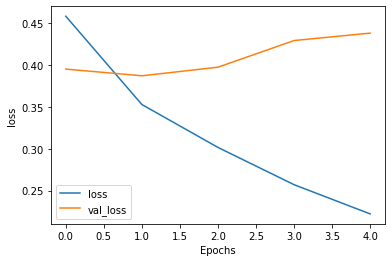

In [25]:
plot_graphs(history, 'loss') #파란색이 훈련데이터 

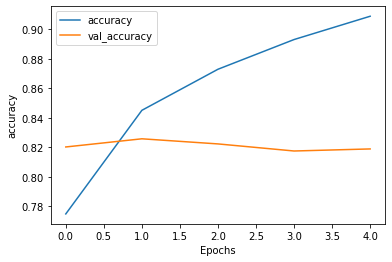

In [26]:
plot_graphs(history, 'accuracy') 

In [29]:
DATA_OUT_PATH = 'data-out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [30]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [31]:
model.evaluate(test_input, test_label)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.3876 - accuracy: 0.8263


[0.3875744938850403, 0.8263199925422668]